In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
import nltk
import nltk
import re
from nltk.corpus import stopwords
import string
from nltk.stem.porter import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import WordNetLemmatizer
import spacy
from nltk.corpus import wordnet
from cleantext import clean
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import contractions
import unicodedata
import warnings
# from wordcloud import WordCloud
warnings.simplefilter(action='ignore', category=FutureWarning)

### 1. Load dataset and wrangle data to relevant cols for merging
- Load 2 sets of data to get ID, Name, Topic, Topic Category
- Merge df will be renamed to above titles
- Merged df will be use for training/testing of model

In [3]:
# Import course with topic data set
df = pd.read_excel('BEG listing as at 11 Jan 22.xlsx')
df.head()

,S/N,Business Event Group 1,Business Event Group 2,Internal/External/Overseas,Business Event Type Name,Business Event ID,Business Event Name,Organizer,Competencies,Object Status,Lock Flag,Status,Course Run Start Date,Course Run End Date,Course Duration (Hours),Course Fees
0,1,Organisation Devt,Service Excellence,External,Responsiveness In Frontline Customer Svs,712,Responsiveness In Frontline Customer Svs,Civil Service College -IPAM,ESS: Core - Customer Focus; Commn & Influencin...,Active,N,Approved,2015-12-07 00:00:00,2015-12-08 00:00:00,16.0,308.0
1,2,Personal Devt & Effectiveness,Personal Devt,External,Mastering Telephone Service Skills,13012016,Mastering Telephone Service Skills,Civil Service College -IPAM,NaN,Active,N,Approved,2016-01-13 00:00:00,2016-01-14 00:00:00,16.0,332.5
2,3,Personal Devt & Effectiveness,Personal Devt,Internal,Aspiration Pathfinder,20092005,Aspiration Pathfinder,JTC Academy,NaN,Active,N,Approved,2005-09-20 00:00:00,2005-09-21 00:00:00,16.0,400.0
3,4,Organisation Devt,Knowledge Mgmt,Internal,CMD L&S-Briefg & Lessons-Crisis Comms,22072010,CMD L&S-Briefg & Lessons-Crisis Comms,Communications Division,NaN,Active,N,Approved,2010-07-22 00:00:00,2010-07-22 00:00:00,2.0,3.7
4,5,NaN,NaN,NaN,NaN,50000119,Strategic Planning,Quest Communications Pte Ltd,NaN,NaN,N,Cancelled,2000-08-18 00:00:00,2000-10-09 00:00:00,12.0,200.0


In [4]:
#Get relevant cols for merging
df_topic = df[['Business Event ID', 'Business Event Name', 'Business Event Group 2']]
df_topic.sample(10)

,Business Event ID,Business Event Name,Business Event Group 2
25176,50085158,Rocscience RS2 Training,Civil & Structural Engrg
16617,50058636,Making The Most Out Of Your Time-Div 1/2,Personal Devt
22976,50079183,Bored Tunnel Excavation Management,Civil & Structural Engrg
18551,50065478,Understanding Ethics&Dealg Ethical Issue,"Accounting, Finance & Audit"
10223,50043523,Nat'l Conf on Wkplace Health Promotion,Human Resource Mgmt
11419,50046811,Proj Mgt Prof Cert Curriculum,Personal Effectiveness
6497,50034960,Risk Assessment Workshop,Security
13579,50051382,Termination & Suspensn of Const Contract,Civil & Structural Engrg
7072,50036531,Makg Memory Work To Improve Productivity,Personal Devt
4130,50027791,Electrical Safety & Electrical Installat,Mechanical & Electrical


In [5]:
# Load dataset to get other category data
df2 = pd.read_excel('sample.xlsx')
df2.head()


,Event,BEG1,BEG2,BEG3-Original,Organizer,BEG3-Edited1,BEG3-Edit Internal,BEG 1,BEG4-New BET1
0,712.0,Organisation Devt,Service Excellence,External,Civil Service College -IPAM,External,NaN,Organisation Devt,Organisation Devt
1,13012016.0,Personal Devt & Effectiveness,Personal Devt,External,Civil Service College -IPAM,External,NaN,Personal Devt & Effectiveness,Personal Devt & Effectiveness
2,20092005.0,Personal Devt & Effectiveness,Personal Devt,Internal,JTC Academy,Internal,NaN,Personal Devt & Effectiveness,Personal Devt & Effectiveness
3,22072010.0,Organisation Devt,Knowledge Mgmt,Internal,Communications Division,Internal,NaN,Organisation Devt,Organisation Devt
4,50000119.0,NaN,NaN,External,Quest Communications Pte Ltd,External,NaN,Grand Total,NaN


In [6]:

# Remove rows with Nan values in Event Col so that can convert dtypes
df2 = df2.dropna(subset=['Event'])

#Convert from float to int
df2 = df2.astype({'Event': 'int64'})

#Selecting Relevant columns to merge
df2_topic = df2[['Event','BEG4-New BET1']]
df2_topic


,Event,BEG4-New BET1
0,712,Organisation Devt
1,13012016,Personal Devt & Effectiveness
2,20092005,Personal Devt & Effectiveness
3,22072010,Organisation Devt
4,50000119,NaN
...,...,...
32220,50086983,Organisation Devt
32221,50086984,Staff Development Programme
32222,50086984,Staff Development Programme
32223,50086987,Personal Devt & Effectiveness


In [7]:
# Merge df_topic and df2_topic on event id
df_combine = df_topic.merge(df2_topic, how = 'left', left_on='Business Event ID', right_on='Event')

#Remove 1 col of event id and drop rows with NaN values for a clean data set
df_combine = df_combine.dropna().drop(['Event'], axis =1)

# Rename columns
df_combine = df_combine.rename({'Business Event ID': 'crs_id', 'Business Event Name': 'crs_title', 'Business Event Group 2':'crs_topics', 'BEG4-New BET1': 'topics_cat'}, axis =1)

In [8]:
df_combine

,crs_id,crs_title,crs_topics,topics_cat
0,712,Responsiveness In Frontline Customer Svs,Service Excellence,Organisation Devt
1,13012016,Mastering Telephone Service Skills,Personal Devt,Personal Devt & Effectiveness
2,20092005,Aspiration Pathfinder,Personal Devt,Personal Devt & Effectiveness
3,22072010,CMD L&S-Briefg & Lessons-Crisis Comms,Knowledge Mgmt,Organisation Devt
5,50007327,LMDP-Effective Project Management,Personal Effectiveness,Personal Devt & Effectiveness
...,...,...,...,...
32164,50086987,Systems Engineering Foundation Course,Personal Effectiveness,Personal Devt & Effectiveness
32165,50086987,Systems Engineering Foundation Course,Personal Effectiveness,Personal Devt & Effectiveness
32166,50086987,Systems Engineering Foundation Course,Personal Effectiveness,Personal Devt & Effectiveness
32167,50086988,Effective Business Grammar Skills,Communication,Personal Devt & Effectiveness


--------------

### 2. Do NLP for crs_title

In [9]:
# set list of stop words
stop_words = set(stopwords.words('english'))
w_list =['training', 'programme','course', 'trg', 'crs', 'program', 'prog']
for word in w_list:
    stop_words.add(word)

In [10]:
#create func to take pos
def pos_tag_wordnet(tagged_tokens):
    tag_map = {'j': wordnet.ADJ, 'v': wordnet.VERB, 'n': wordnet.NOUN, 'r': wordnet.ADV}
    new_tagged_tokens = [(word, tag_map.get(tag[0].lower(), wordnet.NOUN))
                            for word, tag in tagged_tokens]
    return new_tagged_tokens

In [11]:
def text_processing(review):
    
    #tokenize
    text = nltk.word_tokenize(review)
    
    #conver to lowercase 
    text = [t.lower() for t in text]
    
    # remove symbol
    text = [re.sub(r'^\d\w\s','',t) for t in text]
    
    #remove brackets
    text = [t.replace("(","").replace(")","") for t in text]
     
    # remove punctuation
    text = [t for t in text if t.isalnum()]
    
    # remove stopwords
    text  = [t for t in text if t not in  stop_words]
    
    #remove contractions
    text = [contractions.fix(t) for t in text]
    
    #Remove numbers
    text = [re.sub('\w*\d\w*', '', t) for t in text]
    
    #Remove ascii char
    text = [unicodedata.normalize('NFKD', t).encode('ascii', 'ignore').decode('utf-8', 'ignore') for t in text]
     
    #Remove empty tokens
    text = [t for t in text if t]
        
    #POS tagging
    text = nltk.pos_tag(text)
    text = pos_tag_wordnet(text)
    
    # Lemmatization
    lemma = WordNetLemmatizer()
    text = [lemma.lemmatize(t,tag) for t,tag in text]
    
    # #Join tokens
    # text = ' '.join(text)
    
    return text

In [12]:
df_combine['crs_title_pro'] = df_combine['crs_title'].apply(text_processing)

In [13]:
df_combine

,crs_id,crs_title,crs_topics,topics_cat,crs_title_pro
0,712,Responsiveness In Frontline Customer Svs,Service Excellence,Organisation Devt,"[responsiveness, frontline, customer, svs]"
1,13012016,Mastering Telephone Service Skills,Personal Devt,Personal Devt & Effectiveness,"[master, telephone, service, skill]"
2,20092005,Aspiration Pathfinder,Personal Devt,Personal Devt & Effectiveness,"[aspiration, pathfinder]"
3,22072010,CMD L&S-Briefg & Lessons-Crisis Comms,Knowledge Mgmt,Organisation Devt,"[cmd, l, comms]"
5,50007327,LMDP-Effective Project Management,Personal Effectiveness,Personal Devt & Effectiveness,"[project, management]"
...,...,...,...,...,...
32164,50086987,Systems Engineering Foundation Course,Personal Effectiveness,Personal Devt & Effectiveness,"[system, engineering, foundation]"
32165,50086987,Systems Engineering Foundation Course,Personal Effectiveness,Personal Devt & Effectiveness,"[system, engineering, foundation]"
32166,50086987,Systems Engineering Foundation Course,Personal Effectiveness,Personal Devt & Effectiveness,"[system, engineering, foundation]"
32167,50086988,Effective Business Grammar Skills,Communication,Personal Devt & Effectiveness,"[effective, business, grammar, skill]"


------------------------

### EDA before training the model for prediction to see if we need to adjust features/labels

In [14]:
#Check number of topics and chart how much is there for each
df_combine['crs_topics'][df_combine['topics_cat']=='Corporate Functions'].value_counts()


Information Technology            4728
Accounting, Finance & Audit       1425
Law                               1028
Procurement & Contracts Mgmt       843
Human Resource Mgmt                452
Human Resource Devt                242
Corporate Communications           233
Technology                         137
Research & Statistics              135
Valuation                          100
Resource Mgmt                       25
Building Information Modelling       2
Name: crs_topics, dtype: int64

In [15]:
df_combine['topics_cat'].value_counts()

Corporate Functions              9350
Personal Devt & Effectiveness    8607
Technical                        6365
Organisation Devt                4255
Industry Devt                     887
Staff Development Programme       707
Leadership                         47
Name: topics_cat, dtype: int64

In [16]:
# Function to build chart with seaborn

def create_chart(col_main, col_filter, filter_name:list):
    count = 0
    fig, axes = plt.subplots(1,len(filter_name), figsize = (20,4), sharey = True)
    for name in filter_name:
        chart = sns.countplot(col_main[col_filter==name], order = col_main[col_filter==name].value_counts().index, ax=axes[count])
        chart.set_title(name)
        for labels in chart.get_xticklabels():
            labels.set_rotation(90)
        for i in chart.containers:
            chart.bar_label(i,)
        count+=1
    plt.show()

In [18]:
categories = df_combine['topics_cat'].unique()

In [19]:
categories

array(['Organisation Devt', 'Personal Devt & Effectiveness', 'Technical',
       'Corporate Functions', 'Industry Devt',
       'Staff Development Programme', 'Leadership'], dtype=object)

In [21]:
#Creating list of categories to loop through
list1 = [i for i in categories[:3]]
list2 = [i for i in categories[3:]]

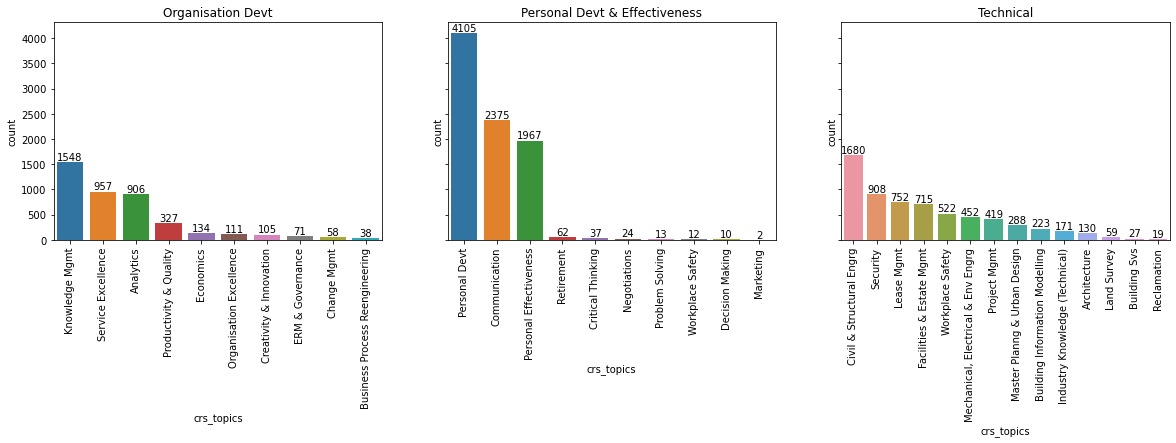

In [22]:
#Chart for list 1
for lst in [list1,list2]:
    create_chart(df_combine['crs_topics'],df_combine['topics_cat'],lst)

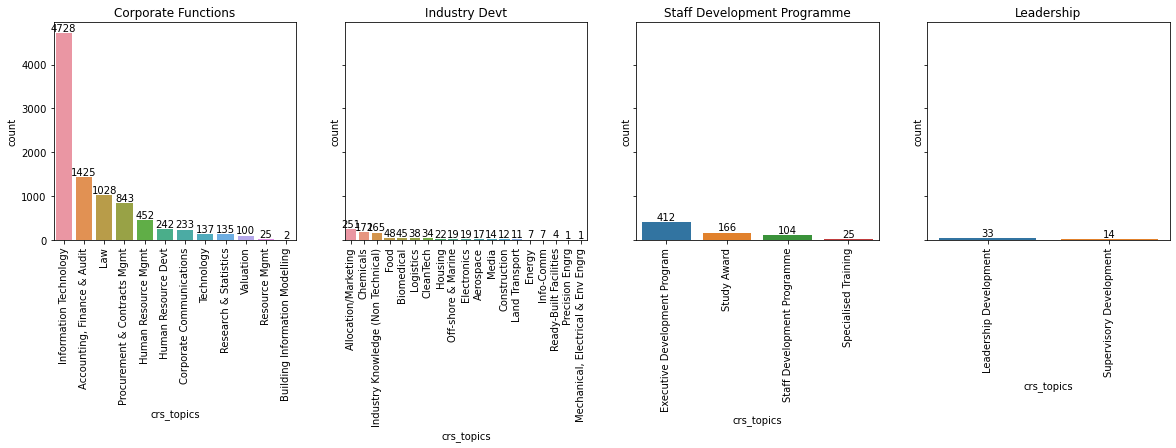

In [23]:
#Charts for list 2
create_chart(df_combine['crs_topics'],df_combine['topics_cat'],list2)

**Observations**
- Dataset is imbalance with more entries for some topics
- Some topics appears in different multiple categories

**Considerations**
- Need to balance dataset
    - need to mix oversampling and undersampling
- Do we also want to group some of the topics with very little entries?

-------------------------------------------------------------------

### Train-Test Split of data before normalisation or encoding

In [24]:
# Creating new columns and re-categories some of the topics to the correct cat
df_combine['new_crs_topics'] =  df_combine['crs_topics'] 
df_combine['new_topics_cat'] =  df_combine['topics_cat'] 

df_combine.loc[(df_combine["new_crs_topics"] == "Building Information Modelling"), "new_topics_cat"] = 'Technical'
df_combine.loc[(df_combine["new_crs_topics"] == "Mechanical, Electrical & Env Engrg"), "new_topics_cat"] = 'Technical'

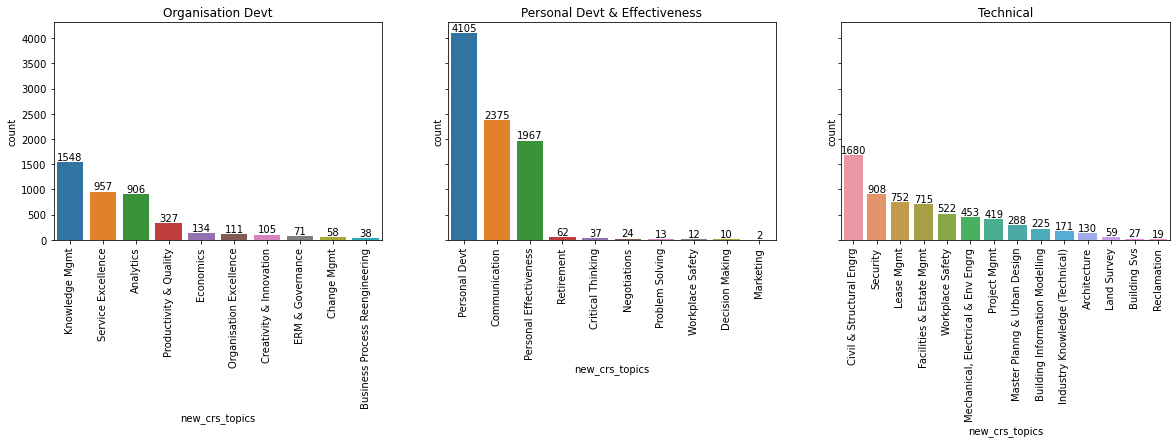

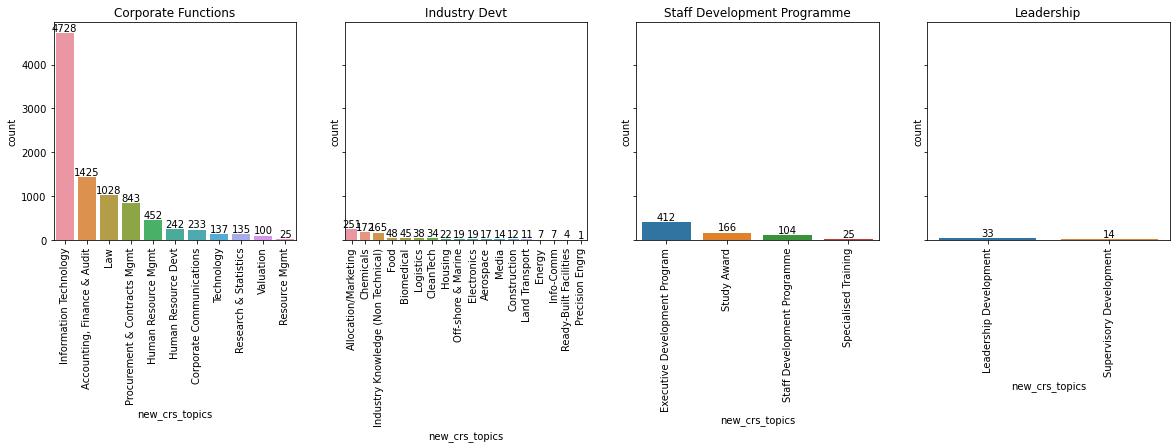

In [33]:
# Check to see if recatorgorization successful
for lst in [list1,list2]:
    create_chart(df_combine['new_crs_topics'],df_combine['new_topics_cat'],lst)

In [34]:
# need to group those with lower count together as a topic other-{topic cat}
def grp_topic(data, col_to_chng: str, filter_col:str):
    cat_list = [cat for cat in data[filter_col].unique()]
    for i in cat_list:
        list_change = []
        unique_ct = data[col_to_chng][data[filter_col]==i].value_counts()
        df_uc = pd.DataFrame(unique_ct).reset_index()
        df_uc = df_uc.rename(columns = {'index':'topics', 'new_crs_topics': 'count'})
        for j in df_uc['topics'][df_uc['count']<=20]:
            list_change.append(j)
        data[col_to_chng] = data[col_to_chng].replace(dict.fromkeys(list_change,f'Others-{i}'))
    return data


       

In [35]:
df_combine = grp_topic(df_combine,'new_crs_topics', 'new_topics_cat')
# df_combine['new_crs_topics'] = df_combine['new_crs_topics'].replace(dict.fromkeys(['Others-Leadership'],'Supervisory Development'))

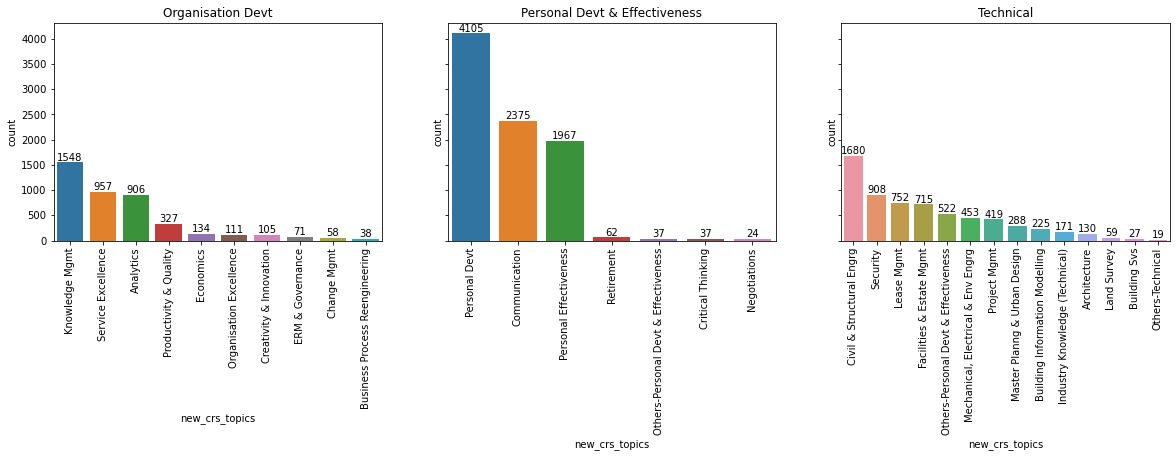

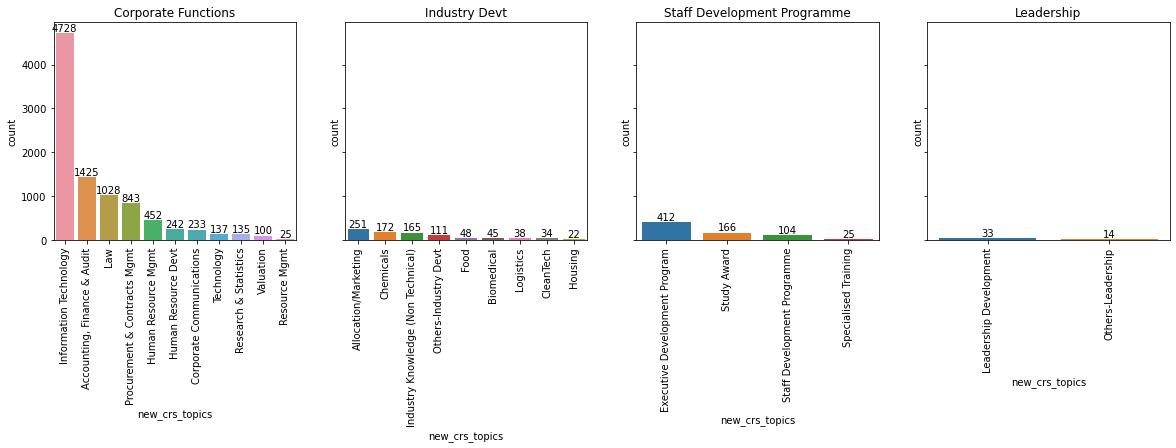

In [38]:
for lst in [list1,list2]:
    create_chart(df_combine['new_crs_topics'],df_combine['new_topics_cat'],lst)

In [112]:
#Split the dataset before treatment to prevent data leak
x_train, x_test, y_train, y_test = train_test_split(df_combine['crs_title_pro'], 
                                                    df_combine['new_crs_topics'], 
                                                    test_size=0.30, 
                                                    random_state=123, 
                                                    stratify = df_combine['new_crs_topics'])

In [113]:
#Vectorize the features
vect = TfidfVectorizer(analyzer=lambda x:x)
x_train_v = vect.fit_transform(x_train)
x_test_v = vect.transform(x_test)

In [114]:
#Check shape of train and test 
x_train_v.shape, x_test_v.shape

((21152, 5516), (9066, 5516))

In [115]:
#One hot encoding via get_dummies
oh_enc = OneHotEncoder(handle_unknown='ignore') 
y_train_e_oh = oh_enc.fit_transform(np.array(y_train).reshape(-1,1)).toarray()


In [157]:
#Labelencode the labels
label = LabelEncoder()
y_train_e_l = label.fit_transform(y_train)
y_train_e_l


array([26, 27, 26, ...,  9, 26, 27])

In [117]:
model = RandomForestClassifier(class_weight='balanced')

### Fitting and predicitng with RandomForest (Label Encoding)

In [162]:
model.fit(x_train_v, y_train_e_l)
y_pred_e = model.predict(x_test_v)
y_pred = label.inverse_transform(y_pred_e)
df_compare = pd.DataFrame({'crs_title': x_test, 'actual_crs_topics': y_test, 'pred_crs_topics':y_pred})
df_compare.sample(20)

,crs_title,actual_crs_topics,pred_crs_topics
883,"[account, process]",Information Technology,"Accounting, Finance & Audit"
11240,"[writg, svc, approach]",Communication,Communication
25125,"[basic, project, mgt, best, practice]",Procurement & Contracts Mgmt,Procurement & Contracts Mgmt
19995,"[art, effective, listening]",Personal Devt,Personal Devt
5759,"[tony, buzan, speed, read, km]",Personal Devt,Personal Devt
30679,"[risk, mgmt, professional]",Project Mgmt,Project Mgmt
11855,"[message, input, electronic, message, board]",Information Technology,Personal Devt
3777,"[it would, technology]",Information Technology,Information Technology
30041,"[petrochemical, intro]",Chemicals,Chemicals
15829,"[workplace, safety, awareness]",Security,Security


In [163]:
print(classification_report(y_true=y_test,y_pred=y_pred))

### Consider K class accuracy classification -  to research

                                      precision    recall  f1-score   support

         Accounting, Finance & Audit       0.84      0.77      0.80       428
                Allocation/Marketing       0.59      0.72      0.65        75
                           Analytics       0.96      0.99      0.97       272
                        Architecture       0.74      0.36      0.48        39
                          Biomedical       0.80      0.92      0.86        13
      Building Information Modelling       0.89      1.00      0.94        68
                        Building Svs       1.00      1.00      1.00         8
      Business Process Reengineering       0.75      0.55      0.63        11
                         Change Mgmt       0.78      0.82      0.80        17
                           Chemicals       0.76      0.71      0.73        52
            Civil & Structural Engrg       0.83      0.78      0.81       504
                           CleanTech       0.50      0.50      

In [150]:
from sklearn.model_selection import GridSearchCV
# Number of trees in random forest
n_estimators = list(range(50, 210, 10))
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [2,3,4,5]
# max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [153]:
rf_grid = GridSearchCV(estimator=model, param_grid=param_grid, cv =3, n_jobs =4, verbose=2)

In [154]:
rf_grid.fit(x_train_v, y_train_e_l)

Fitting 3 folds for each of 1024 candidates, totalling 3072 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=4,
             param_grid={'bootstrap': [True, False], 'max_depth': [2, 3, 4, 5],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [50, 60, 70, 80, 90, 100, 110, 120,
                                          130, 140, 150, 160, 170, 180, 190,
                                          200]},
             verbose=2)

In [155]:
rf_grid.best_params_

{'bootstrap': False,
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 180}

In [159]:
model_best = RandomForestClassifier(bootstrap= False, max_depth = 5, max_features='auto',
                                    min_samples_leaf= 1, min_samples_split = 2,
                                    n_estimators=180, class_weight='balanced')

model_best.fit(x_train_v, y_train_e_l)
y_pred_e = model.predict(x_test_v)

In [167]:
y_pred2 = label.inverse_transform(y_pred_e.flatten())

In [168]:
### Fitting and predicitng with RandomForest (Label Encoding) - with best params

# y_pred = label.inverse_transform(y_pred_e)
df_compare = pd.DataFrame({'crs_title': x_test, 'actual_crs_topics': y_test, 'pred_crs_topics':y_pred2})
df_compare.sample(20)

,crs_title,actual_crs_topics,pred_crs_topics
10804,"[econ, speaker, series]",Knowledge Mgmt,Knowledge Mgmt
4101,"[acl, data, analysis]",Information Technology,Information Technology
19756,"[essential, communication, skill]",Communication,Communication
26787,"[treecare, seminar]",Industry Knowledge (Non Technical),Industry Knowledge (Non Technical)
11659,[],Knowledge Mgmt,Organisation Excellence
15766,"[workplace, safety, awareness]",Security,Security
4824,[sibcon],"Mechanical, Electrical & Env Engrg",Organisation Excellence
17829,"[jtc, security, awareness]",Information Technology,Information Technology
308,"[word, adv]",Information Technology,Information Technology
11478,"[mgt, work, affectg, pub, street]",Civil & Structural Engrg,Civil & Structural Engrg


In [171]:
print(classification_report(y_true=df_compare['actual_crs_topics'],y_pred=df_compare['pred_crs_topics']))

                                      precision    recall  f1-score   support

         Accounting, Finance & Audit       0.84      0.77      0.80       428
                Allocation/Marketing       0.59      0.72      0.65        75
                           Analytics       0.96      0.99      0.97       272
                        Architecture       0.74      0.36      0.48        39
                          Biomedical       0.80      0.92      0.86        13
      Building Information Modelling       0.89      1.00      0.94        68
                        Building Svs       1.00      1.00      1.00         8
      Business Process Reengineering       0.75      0.55      0.63        11
                         Change Mgmt       0.78      0.82      0.80        17
                           Chemicals       0.76      0.71      0.73        52
            Civil & Structural Engrg       0.83      0.78      0.81       504
                           CleanTech       0.50      0.50      